<a href="https://colab.research.google.com/github/bhkwon89/cp2/blob/main/EDAnPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False 

In [ ]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
pip install -U pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas_profiling

In [ ]:
path_celeb = '/content/drive/MyDrive/cp2/celebrity.csv'
path_char  = '/content/drive/MyDrive/cp2/chat_data.csv'
path_charR = '/content/drive/MyDrive/cp2/chat_raw.csv'
path_room  = '/content/drive/MyDrive/cp2/room_info.csv'
path_sticker = '/content/drive/MyDrive/cp2/sticker_price.csv'

df_celeb = pd.read_csv(path_celeb,encoding='CP949')
df_chat  = pd.read_csv(path_char,encoding='CP949')
df_chatR = pd.read_csv(path_charR,encoding='CP949')
df_room  = pd.read_csv(path_room,encoding='CP949')
df_sticker  = pd.read_csv(path_sticker)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
# 데이터 전처리. (# 1번만 할 것)

# 1. 데이터 맨 뒤의 쓰레기값 제거
df_chat = df_chat[:-8]  

# 2. id type 결측치 채우기
df_chat.loc[df_chat['channel_member_count'].isna() & df_chat['id type'].isna(), 'id type'] = 'fan'

# 3. new_type 추가(파일의 종류도 분류)
df_chat['new_type'] = df_chat['type'].copy()

df_chat.loc[(df_chat['type'] == 'FILE') & (df_chat['message'].str.contains('/fancimm/sticker')), 'new_type'] = 'STICKER'
df_chat.loc[(df_chat['type'] == 'FILE') & ~(df_chat['message'].str.contains('/fancimm/sticker')) & ( (df_chat['message'].str.contains('.jpe') ) | (df_chat['message'].str.contains('.png')) | (df_chat['message'].str.contains('.jpg')) ), 'new_type'] = 'IMAGE'
df_chat.loc[(df_chat['type'] == 'FILE') & ~(df_chat['message'].str.contains('/fancimm/sticker')) & ((df_chat['message'].str.contains('.mp4')) | (df_chat['message'].str.contains('.wav')) | (df_chat['message'].str.contains('.mov')) ), 'new_type'] = 'VIDEO'

# 4. year, month, day, hour 컬럼 추가
df_chat['year'] = pd.to_datetime(df_chat['created_at']).dt.year
df_chat['month'] = pd.to_datetime(df_chat['created_at']).dt.month
df_chat['day'] = pd.to_datetime(df_chat['created_at']).dt.day
df_chat['hour'] = pd.to_datetime(df_chat['created_at']).dt.hour

# 5. sender_id가 null이면 드랍 (데이터 확인 결과 sender_id가 없으면 id type이 ADMM이다. 개수는 총 16개)
df_chat = df_chat.dropna(subset=['sender_id'])

# 6. 'owner' 컬럼 추가 (해당 방의 주인)
#   a. 채널(key)-주인(value) 딕셔너리 생성
#   b. 딕셔너리 -> 데이터프레임(df_owner) 변환
#   c. df_chat과 df_owner를 left 조인     (for 문보다 조인이 훨씬 빠름)

dict_owner = {}
list_ch = df_chat['channel_url'].unique()
for ch in list_ch:
  df_tmp = df_chat[df_chat['channel_url'] == ch]
  tmp = df_tmp[df_tmp['id type'] == 'celeb'].groupby('sender_id').size()
  if len(tmp) == 0:
    dict_owner[ch] = np.nan
  else:  
    dict_owner[ch] = tmp.index[tmp.argmax()]

df_owner = pd.DataFrame(columns = ['channel_url', 'owner'])
for k, v in dict_owner.items():
  df_owner = df_owner.append(pd.DataFrame({'channel_url':[k], 'owner':[v]}))

df_chat = pd.merge(left = df_chat , right = df_owner, how = "left", on = "channel_url")

#7. channel 명이 없는 방 제거 (삭제된 방으로 간주한다)
df_chat_closed = df_chat[df_chat['channel_name'].isna()]     ## room 시트 현재 존재하는 방만 있기 때문에 머지 불가
df_chat = df_chat[~(df_chat['channel_name'].isna())]


#8. owner가 없는 방 제거
df_chat = df_chat[~(df_chat['owner'].isna())]
#df_chat_no_owner = df_chat[]

#9. room 시트와 머지
df_chat = pd.merge(left = df_chat , right = df_room[['channel_url', 'channel_member_count']], how = "left", on = "channel_url")
# 확인 결과 머지 않되는 부분은 없음

#10. sticker info와 머지
df_chat = pd.merge(left = df_chat , right = df_sticker[['message', 'price']], how = "left", on = "message")

#11. 탈퇴한 날짜 컬럼 추가 (채팅 내역에 ~님이 나갔습니다. 가 있을 경우 채팅방에서 나간 것)
df_chat['탈퇴한 날짜'] = [np.nan]*len(df_chat)

for i in df_chat[df_chat['message'].str.contains('님이 나갔습니다.')].index:
  df_chat.loc[i, '탈퇴한 날짜'] = df_chat['created_at'][i]

df_chat['YMDH'] = df_chat['year'] * 1000000 + df_chat['month'] * 10000 + df_chat['day'] * 100 + df_chat['hour']
df_chat[df_chat['channel_name'].str.contains('예꿍')][df_chat['price'] >0][['created_at','price']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#pr=df_chat.profile_report()

In [ ]:
#pr

In [ ]:
# 전체 데이터에서 특정 방 데이터만 가져옴
def GetRoomDataframeFromChat(df_chat, channel_url):
  dfByRoom = df_chat[df_chat['channel_url'] == channel_url]
  return dfByRoom

# 전체 데이터에서 데이터를 방별로 리스트에 저장하여 가져옴
def GetListRoomDataframeFromChat(df_chat):
  listDfByRoom = []
  listChannelUrl = df_chat['channel_url'].unique()
  
  for channel_url in listChannelUrl:
    listDfByRoom.append(GetRoomDataframeFromChat(df_chat, channel_url))
  return listDfByRoom

# 특정 방 데이터에서 특정 유저의 데이터를 가져옴
def GetUserDataframeFromRoom(dfByRoom, user_email):
  dfByUser = dfByRoom[dfByRoom['sender_id'] == user_email]
  return dfByUser

# 특정 방 데이터에서 데이터를 유저별로 리스트에 저장하여 가져옴
def GetListUserDataframeFromRoom(dfByRoom):
  listDfByUser = []
  list_email = dfByRoom['sender_id'].unique()
  
  for email in list_email:
     listDfByUser.append(GetUserDataframeFromRoom(dfByRoom, email))

  return listDfByUser


# 특정 유저 데이터를 넣으면 그 유저의 RFM 분석
now_time = pd.to_datetime(df_chat['created_at'].max())  # df_chat 상 가장 최근 날짜
def GetRFMdataFromUser(dfByUser):
  active_days = (pd.to_datetime(dfByUser['created_at'].max()) - pd.to_datetime(dfByUser['created_at'].min())).days
  R = (now_time -pd.to_datetime(dfByUser['created_at'].max())).days
  F = (lambda x,y: x/y if y != 0 else x)(len(dfByUser), active_days)
  L = (pd.to_datetime(dfByUser['created_at'].max())-pd.to_datetime(dfByUser['created_at'].min())).days
  MNum = len((dfByUser[dfByUser['new_type'] == 'MESG']['message']))
  MLen = len(''.join(dfByUser[dfByUser['new_type'] == 'MESG']['message']))
  MS = dfByUser['price'].sum()
  M = MS + 30 * MNum
  Out = False
  #print(dfByUser['message'].str.contains('님이 나갔습니다.'))

  if True in list(dfByUser['message'].str.contains('님이 나갔습니다.')):
    
    Out = True
    
  #M = MLen + 
  # L : 얼마나 이 방에 오래 있었는가 ( 최근 메시지 날짜 - 첫 메시지 날짜 )
  # MNum : 채팅 친 회수, MLen : 전체 메세지 길이, MS : 스티커 가격
  # M : 채팅 횟수 * 30(원) + 도네 가격 
  return R, F, L, MNum, MLen, MS, M, Out

# 데이터의 시간별 분포 (입력으로 전체, 방, 유저 뭘 넣어도 상관없음)
def GetMessageByTheTimeFromAny(df):
  return df.groupby(['hour']).size()


from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
# 클러스터링
def GetClusterFromDataframe(df, num_cluster=3):
  sc = MinMaxScaler()
  cc_scaled = sc.fit_transform(df)
  kmeans = KMeans(num_cluster, random_state=0)

  clusters = kmeans.fit(cc_scaled)
  return clusters.labels_



In [ ]:
listDfByRoom = GetListRoomDataframeFromChat(df_chat)

In [ ]:
# 특정 방 Owner에 대한 RFM
dfRfmByRoomOnlyOwner = pd.DataFrame(columns=['channel_name','channel_url', 'R', 'F', 'L', 'MNum', 'MLen', 'MS', 'M'])
count_NoOwnerRoom = 0

for dfByRoom in listDfByRoom:
  dfByRoom = dfByRoom[dfByRoom['owner'] == dfByRoom['sender_id']]

  if len(dfByRoom) == 0:
    count_NoOwnerRoom += 1
    continue

  listDfByUser = GetListUserDataframeFromRoom(dfByRoom)
  
  SUM = {'R':0, 'F':0, 'L':0, 'MNum':0, 'MLen':0, 'MS':0, 'M':0}
  for dfByUser in listDfByUser:
    
    R, F, L, MNum, MLen, MS, M = GetRFMdataFromUser(dfByUser)
    SUM['R'] += R
    SUM['F'] += F
    SUM['L'] += L
    SUM['MNum'] += MNum
    SUM['MLen'] += MLen
    SUM['MS'] += MS
    SUM['M'] += M
    
  #print(listDfByUser)
  if len(listDfByUser) == 0:
    average_R = np.nan
    average_F = np.nan
    average_L = np.nan
    average_MNum = np.nan
    average_MLen = np.nan
    average_MS = np.nan
    average_M = np.nan
    
  else:
    average_R = SUM['R']/len(listDfByUser)
    average_F = SUM['F']/len(listDfByUser)
    average_L = SUM['L']/len(listDfByUser)
    average_MNum = SUM['MNum']/len(listDfByUser)
    average_MLen = SUM['MLen']/len(listDfByUser)
    average_MS = SUM['MS']/len(listDfByUser)
    average_M = SUM['M']/len(listDfByUser)

  #print('방 평균 R : ', average_R, '방 평균 F : ', average_F, '방 평균 L : ', average_L, '방 평균 MM : ', average_MM, '방 평균 MS : ', average_MS)
  df_tmp = pd.DataFrame({'channel_name' : [dfByRoom.iloc[0, 0]],
                         'channel_url' : [dfByRoom.iloc[0, 1]], 
                         'R' : [average_R], 
                         'F' : [average_F], 
                         'L' : [average_L],
                         'MLen' :[average_MLen], 
                         'MNum' :[average_MNum], 
                         'MS' :[average_MS],
                         'M' : [average_M]})
  dfRfmByRoomOnlyOwner = dfRfmByRoomOnlyOwner.append(df_tmp)

dfRfmByRoomOnlyOwner['cluster'] = GetClusterFromDataframe(dfRfmByRoomOnlyOwner[['R', 'F', 'L', 'M']], 3)
dfRfmByRoomOnlyOwner.to_csv('/content/drive/MyDrive/cp2/owner_RFM_open.csv')
print(count_NoOwnerRoom)

0


In [ ]:
# 특정 방 fan에 대한 RFM
dfRfmByRoomOnlyFan = pd.DataFrame(columns=['channel_name','channel_url', 'R', 'F', 'L', 'MNum', 'MLen', 'MS', 'M'])
dfRfmByFan_Room = pd.DataFrame(columns=['channel_name', 'user_id', 'channel_url', 'R', 'F', 'L', 'MNum', 'MLen', 'MS', 'M'])

count_NoFanRoom = 0

for dfByRoom in listDfByRoom:
  dfByRoom = dfByRoom[dfByRoom['owner'] != dfByRoom['sender_id']]

  if len(dfByRoom) == 0:
    count_NoFanRoom += 1
    continue

  listDfByUser = GetListUserDataframeFromRoom(dfByRoom)
  
  SUM = {'R':0, 'F':0, 'L':0, 'MNum':0, 'MLen':0, 'MS':0, 'M':0, 'Out' : 0}
  

  for dfByUser in listDfByUser:
    
    R, F, L, MNum, MLen, MS, M, Out = GetRFMdataFromUser(dfByUser)
    SUM['R'] += R
    SUM['F'] += F
    SUM['L'] += L
    SUM['MNum'] += MNum
    SUM['MLen'] += MLen
    SUM['MS'] += MS
    SUM['M'] += M
    if Out == True:
      SUM['Out'] += 1

    df_tmp2 = pd.DataFrame({'channel_name' : [dfByUser.iloc[0, 0]],
                         'channel_url' : [dfByUser.iloc[0, 1]], 
                         'user_id' : [dfByUser.iloc[0, 2]],
                         'R' : [R], 
                         'F' : [F], 
                         'L' : [L],
                         'MNum' :[MNum], 
                         'MLen' :[MLen], 
                         'MS' :[MS],
                         'M' :[M]})
    dfRfmByFan_Room = dfRfmByFan_Room.append(df_tmp2)
  
  if len(listDfByUser) == 0:
    average_R = np.nan
    average_F = np.nan
    average_L = np.nan
    average_MNum = np.nan
    average_MLen = np.nan
    average_MS = np.nan
    average_M = np.nan
  else:
    average_R = SUM['R']/len(listDfByUser)
    average_F = SUM['F']/len(listDfByUser)
    average_L = SUM['L']/len(listDfByUser)
    average_MNum = SUM['MNum']/len(listDfByUser)
    average_MLen = SUM['MLen']/len(listDfByUser)
    average_MS = SUM['MS']/len(listDfByUser)
    average_M = SUM['M']/len(listDfByUser)
  
  #print('방 평균 R : ', average_R, '방 평균 F : ', average_F, '방 평균 L : ', average_L, '방 평균 MM : ', average_MM, '방 평균 MS : ', average_MS)
  df_tmp = pd.DataFrame({'channel_name' : [dfByRoom.iloc[0, 0]],
                         'channel_url' : [dfByRoom.iloc[0, 1]], 
                         'R' : [average_R], 
                         'F' : [average_F], 
                         'L' : [average_L],
                         'MNum' :[average_MNum], 
                         'MLen' :[average_MLen], 
                         'MS' :[average_MS],
                         'M' :[average_M],
                         'ActiveFanNum' : [len(listDfByUser)],
                         'StickerNum' : [len(dfByRoom[dfByRoom['new_type']=='STICKER'])],
                         'owner' : [dfByRoom.iloc[0, 17]],
                         'OutNum' : [SUM['Out']]
                         }
                        )
  dfRfmByRoomOnlyFan = dfRfmByRoomOnlyFan.append(df_tmp)

dfRfmByFan_Room['R_rank'] = dfRfmByFan_Room['R'].rank(method='min')
dfRfmByFan_Room['F_rank'] = dfRfmByFan_Room['F'].rank(method='min', ascending=False)
dfRfmByFan_Room['M_rank'] = dfRfmByFan_Room['M'].rank(method='min', ascending=False)

def GetRankFromDataframe(x):
  
  if x < 1*len(dfRfmByFan_Room)/5:
    return 0
  elif x < 2*len(dfRfmByFan_Room)/5:
    return 1
  elif x < 3*len(dfRfmByFan_Room)/5:
    return 2
  elif x < 4*len(dfRfmByFan_Room)/5:
    return 3
  else:
    return 4



dfRfmByFan_Room['R_rank'] = dfRfmByFan_Room['R_rank'].apply(GetRankFromDataframe)
dfRfmByFan_Room['F_rank'] = dfRfmByFan_Room['F_rank'].apply(GetRankFromDataframe)
dfRfmByFan_Room['M_rank'] = dfRfmByFan_Room['M_rank'].apply(GetRankFromDataframe)

  
dfRfmByRoomOnlyFan['cluster'] = GetClusterFromDataframe(dfRfmByRoomOnlyFan[[ 'R', 'F','M']], 5)
dfRfmByRoomOnlyFan.to_csv('/content/drive/MyDrive/cp2/fan_RFM_open.csv')


dfRfmByFan_Room['cluster'] = GetClusterFromDataframe(dfRfmByFan_Room[[ 'R', 'F', 'L', 'M']], 5)
dfRfmByFan_Room.to_csv('/content/drive/MyDrive/cp2/fan-room_RFM_open.csv')

print(count_NoFanRoom)

1


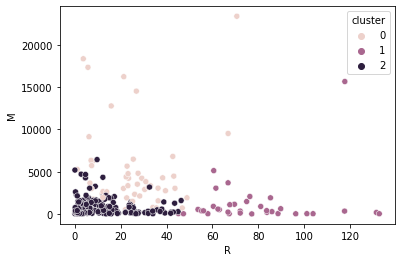

In [ ]:
##### 방분류
import seaborn as sns
fig = sns.scatterplot(x='R', y='M', data=dfRfmByRoomOnlyFan, hue='cluster')
#fig.show()


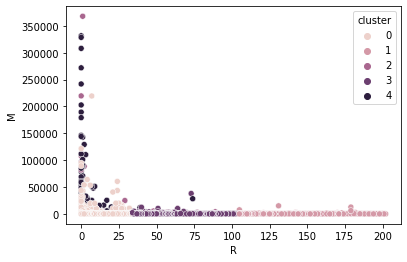

In [ ]:
###### 팬분류
import seaborn as sns
fig = sns.scatterplot(x='R', y='M', data=dfRfmByFan_Room, hue='cluster')
#fig.show()


In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(dfRfmByFan_Room, x='R', y='L', z='M',
              color='cluster')
fig.show()

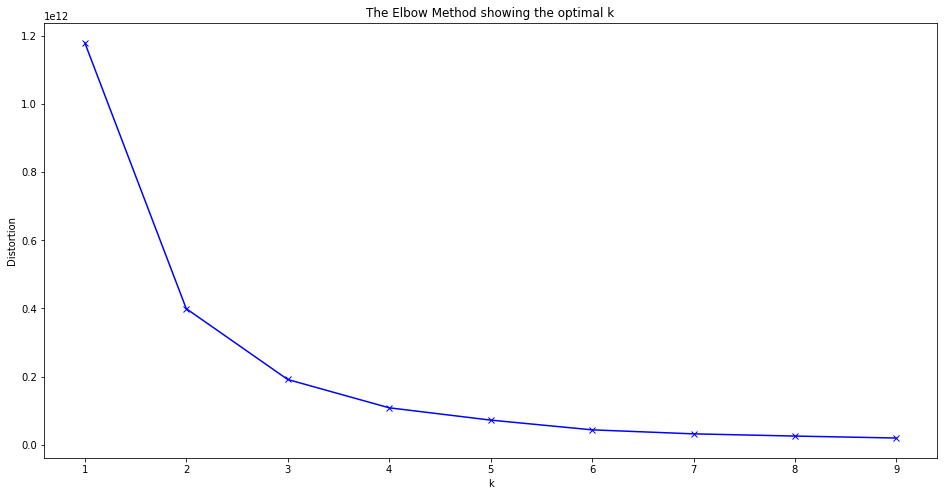

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()